<a href="https://colab.research.google.com/github/tomlincr/breath-sound-detection/blob/main/breath_sound_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import pylab
import wave
from scipy import signal
from scipy.io import wavfile

# Import Audio
Start with single patient single file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Functions courtesy of Duck Dodgers: https://stackoverflow.com/a/54521667/12155200
def spectogram_librosa(_wav_file_):
    (sig, rate) = librosa.load(_wav_file_, sr=None, mono=True,  dtype=np.float32)
    pylab.specgram(sig, Fs=rate)
    pylab.savefig('spectrogram3.png')

def graph_spectrogram_wave(wav_file):
    def get_wav_info(wav_file):
        wav = wave.open(wav_file, 'r')
        frames = wav.readframes(-1)
        sound_info = pylab.fromstring(frames, 'int16')
        frame_rate = wav.getframerate()
        wav.close()
        return sound_info, frame_rate
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=3, figsize=(10, 6))
    pylab.title('spectrogram pylab with wav_file')
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram2.png')


def graph_wavfileread(_wav_file_):
    sample_rate, samples = wavfile.read(_wav_file_)   
    frequencies, times, spectrogram = signal.spectrogram(samples,sample_rate,nfft=1024)
    plt.pcolormesh(times, frequencies, 10*np.log10(spectrogram))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.savefig("spectogram1.png")

In [ ]:
# Imports
wav_pronounced = "breathing.wav"

# Visualisation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


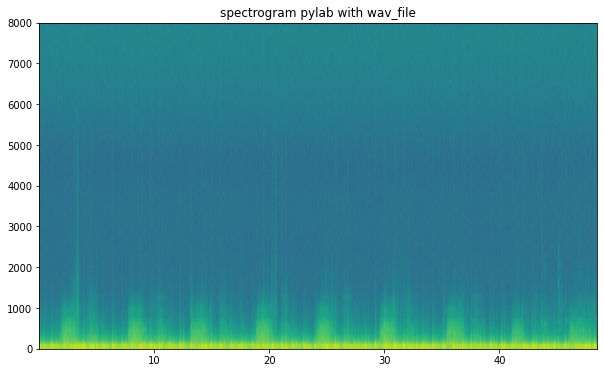

In [ ]:
graph_spectrogram_wave(wav_pronounced)

# Pre-processing

Apply bandpass filter:
1. HPF @ 50 Hz
2. LPF @ 1.5 kHz

In [ ]:
# Extract
sample_rate, samples = wavfile.read(wav_pronounced)   
frequencies, times, spectrogram = signal.spectrogram(samples,sample_rate,nfft=1024)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  


In [ ]:
frequencies.shape

(513,)

In [ ]:
times.shape

(3466,)

In [ ]:
type(spectrogram)

numpy.ndarray

In [ ]:
spectrogram.shape

(513, 3466)

In [ ]:
spectrogram

array([[3.0258353e+02, 9.3516380e+01, 8.3883392e+01, ..., 3.7720356e+01,
        4.6616898e+02, 1.9036145e+02],
       [8.4695557e+02, 3.7189043e+03, 7.6297700e+03, ..., 1.0474536e+03,
        2.4529817e+03, 2.5268159e+03],
       [1.5592571e+03, 1.0686663e+04, 2.2465734e+04, ..., 3.3457322e+03,
        6.0439468e+03, 6.8748403e+03],
       ...,
       [8.6377910e-04, 2.5332142e-03, 1.6270559e-03, ..., 1.4455456e-03,
        1.2554774e-02, 2.5133435e-03],
       [2.7980210e-04, 2.2708653e-03, 2.2522057e-03, ..., 9.1545237e-04,
        1.1183945e-02, 2.0360476e-03],
       [7.2600164e-07, 1.0625549e-03, 1.2769059e-03, ..., 3.5749283e-04,
        5.2615716e-03, 8.9124707e-04]], dtype=float32)

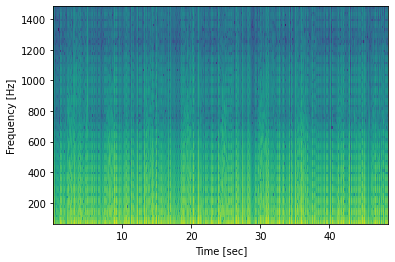

In [ ]:
low = 50
high = 1500

spec = spectrogram[(frequencies>low) & (frequencies < high)]
freqs = frequencies[(frequencies>low) & (frequencies < high)]

def plot_cropped(times, frequencies, spectrogram):
    plt.pcolormesh(times, frequencies, 10*np.log10(spectrogram))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.savefig("spectogram1.png")

plot_cropped(times, freqs, spec)

# Split data
2750 chosen as break point (~80/20) and leaving two complete breaths for identification

In [ ]:
import pandas as pd
X_train = pd.DataFrame(spec[:, :2750].transpose())
X_test = pd.DataFrame(spec[:, 2750:].transpose())

# Create outcome vector
Method = manual annotation:
1. Play wave file in Audacity
2. Visualise amplitude waveform + listen to identify times of start and end of each inspiration
3. Repeat and average
4. Use times to create a binary outcome vector `y` of length `x` where `y=1` during inspiration, else `y=0`

In [ ]:
# Zero initialise outcome vector to same length
# y = np.zeros(len(times), dtype=int)
y = np.zeros(3466, dtype=int)

# Manual time points
# Duration of sample = 48.5 seconds
n_breaths = 9
duration = 48.5

# Times in seconds
breaths = np.array([2, 3.5, # start of inspiration, end of inspiration
                    7.75, 9.5,
                    13.25, 15.0,
                    19, 20.5,
                    24.25, 26.0,
                    29.75, 31.5,
                    35.5, 37,
                    41.25, 42.25,
                    46.5, 48])
# Round to whole points
breaths = np.round((len(times) / duration) * breaths)


# Set y to 1 during these time points
y[int(breaths[0]):int(breaths[1])] = 1
y[int(breaths[2]):int(breaths[3])] = 1
y[int(breaths[4]):int(breaths[5])] = 1
y[int(breaths[6]):int(breaths[7])] = 1
y[int(breaths[8]):int(breaths[9])] = 1
y[int(breaths[10]):int(breaths[11])] = 1
y[int(breaths[12]):int(breaths[13])] = 1
y[int(breaths[14]):int(breaths[15])] = 1
y[int(breaths[16]):int(breaths[17])] = 1


# SPlit
y_train = y[0:2750]
y_test = y[2750:]

In [ ]:
# import pandas as pd
# X_train = pd.read_csv('training.csv')
# X_test = pd.read_csv('valid.csv')

# # Drop 1st index col
# X_test = X_test.drop(X_test.columns[[0]], axis=1)
# X_train = X_train.drop(X_train.columns[[0]], axis=1)

In [ ]:
y_train.shape

(2750,)

In [ ]:
y_test.shape

(716,)

In [ ]:
X_train.shape

(2750, 92)

In [ ]:
X_test.shape

(716, 92)

# Modelling

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=1234)
rfc.fit(X_train, y_train)
score_rfc_fresh = rfc.score(X_test, y_test)

In [ ]:
print("Random Forest Classifier Accuracy (unoptimised): {0:.0%}".format(score_rfc_fresh))

Random Forest Classifier Accuracy (unoptimised): 78%


# XGBoost

In [ ]:
from xgboost.sklearn import XGBClassifier  
import xgboost as xgb

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
print("Train Accuracy {:.2f}%".format(xgb_model.score(X_train, y_train)*100))
print("Test Accuracy {:.2f}%".format(xgb_model.score(X_test, y_test)*100))

Train Accuracy 93.64%
Test Accuracy 78.21%


# Evaluation

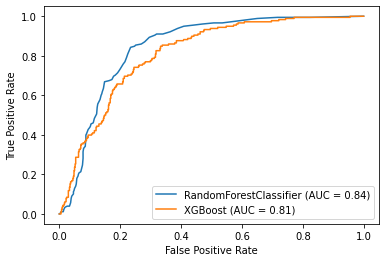

In [ ]:
from sklearn.metrics import plot_roc_curve

ax = plot_roc_curve(rfc, X_test, y_test, name="RandomForestClassifier")
plot_roc_curve(xgb_model, X_test, y_test, ax=ax.ax_, name="XGBoost")
plt.savefig("ROC.png")

In [ ]:
from sklearn.metrics import confusion_matrix

# For RFC

rfc_pred = rfc.predict(X_test)
rfc_conf_mat = confusion_matrix(y_test, rfc_pred)

# For XGB

xgb_pred = xgb_model.predict(X_test)
xgb_conf_mat = confusion_matrix(y_test, xgb_pred)

In [ ]:
print("Confusion Matrix for Random Forest Classifier : \n", rfc_conf_mat)

Confusion Matrix for Random Forest Classifier : 
 [[491  47]
 [107  71]]


In [ ]:
print("Confusion Matrix for XGBoost : \n", xgb_conf_mat)

Confusion Matrix for XGBoost : 
 [[497  41]
 [115  63]]


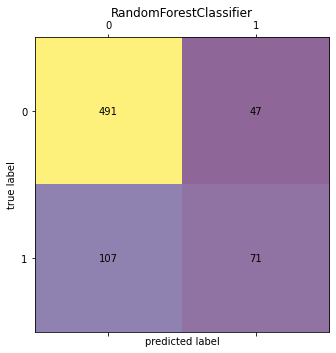

In [ ]:
from sklearn.metrics import confusion_matrix
 
dtree_cfmat = confusion_matrix(y_true=y_test, y_pred=rfc_pred)
 
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(dtree_cfmat, cmap=plt.cm.viridis, alpha=0.6)
for i in range(dtree_cfmat.shape[0]):
    for j in range(dtree_cfmat.shape[1]):
        ax.text(x=j, y=i, s=dtree_cfmat[i, j], va='center', ha='center')
 
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('RandomForestClassifier')
 
plt.tight_layout()
plt.savefig("RFconfmat.png")

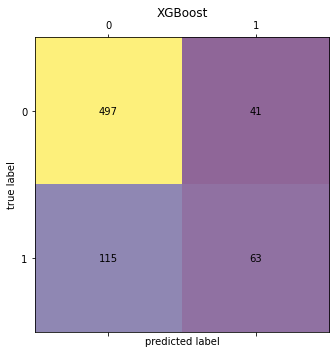

In [ ]:
from sklearn.metrics import confusion_matrix

dtree_cfmat = confusion_matrix(y_true=y_test, y_pred=xgb_pred)
 
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(dtree_cfmat, cmap=plt.cm.viridis, alpha=0.6)
for i in range(dtree_cfmat.shape[0]):
    for j in range(dtree_cfmat.shape[1]):
        ax.text(x=j, y=i, s=dtree_cfmat[i, j], va='center', ha='center')
 
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('XGBoost')
 
plt.tight_layout()
plt.savefig("XGBconfmat.png")